In [82]:
import keras
import tensorflow as tf
from keras import regularizers, models, optimizers, layers
from keras import utils as np_utils
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.layers import MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [127]:
from PIL import Image
from pylab import array, uint8
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import cv2
import random
size = (128, 128)
PATH = '/content/drive/Shareddrives/CASLab ARC/PCB/'

In [ ]:
# load training data
import codecs
print(PATH + 'train.csv')
csvfile = open(PATH + 'train.csv')
reader = csv.reader(x.replace('\0', '') for x in csvfile)
labels = []
 
for line in reader:
    print(line)
    if line == []:
        break
    tmp = [line[0],line[1]]
    labels.append(tmp)
 
csvfile.close() 
picnum = len(labels)
print("Number of training data: ",picnum)
 
X = []
y = []
 
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("normal","0")
    labels[i][1] = labels[i][1].replace("cold_joint","1")
    labels[i][1] = labels[i][1].replace("insufficient","2")
    labels[i][1] = labels[i][1].replace("overheat","3")
    labels[i][1] = labels[i][1].replace("short","4")
    labels[i][1] = labels[i][1].replace("too_much","5")
 
a = 0
items= []
import random
for a in range(0,len(labels)-1):
    items.append(a)
j = 0
for i in random.sample(items,len(labels)-1):
    j += 1
    print("Importing", j)
    img = cv2.imread(PATH+'crop_img/'+labels[i][0])
    img = cv2.resize(img,size)
    X.append(img)
    y.append(labels[i][1])
print("Import successfully!")
print(len(X))
X = np.array(X, dtype=np.float32)
y = np.array(y)
print(type(X))

y = tf.strings.to_number(y, out_type=tf.float32)

In [129]:
y = keras.utils.np_utils.to_categorical(y, num_classes = 6)   #one-hot encoding

for i in range(len(X)):
    X[i] = X[i].astype('float32')
X = X / 255.0
x_train = tf.image.rgb_to_grayscale(X)

y_train = y
print((x_train).shape)
print(x_train.dtype)

(1126, 128, 128, 1)
<dtype: 'float32'>


In [130]:
# model constructing
model = keras.Sequential([
    layers.Conv2D(8,(5,5),
                 strides=(2,2),
                 input_shape=(128, 128, 1),
                 padding='valid',
                 activation='relu',
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(1,1),strides=None),
    layers.Conv2D(8,(3,3),
                 strides=(1,1),
                 padding='valid',
                 activation='relu',
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=None),
    layers.Conv2D(16,(3,3),
                 strides=(1,1),
                 padding='valid',
                 activation='relu',
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=None),
    layers.Conv2D(32,(3,3),
                 strides=(1,1),
                 padding='valid',
                 activation='relu',
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=None),
    layers.Conv2D(64,(3,3),
                 strides=(1,1),
                 padding='valid',
                 activation='relu',
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2),strides=None),
    Dropout(0.3),
    layers.Flatten(),
    layers.Dense(18,activation='relu',
                       kernel_regularizer=regularizers.l2(0.05)),
    Dropout(0.5),
    layers.Dense(6,activation='softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy', 
                  #optimizer=RMSprop(lr=0.00003), #0.000075
                  optimizer='adam', #0.000075
                  metrics=['accuracy'])


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 62, 62, 8)         208       
_________________________________________________________________
batch_normalization_50 (Batc (None, 62, 62, 8)         32        
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 60, 60, 8)         584       
_________________________________________________________________
batch_normalization_51 (Batc (None, 60, 60, 8)         32        
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 16)      

In [132]:
# hyper parameter
batch_size = 32
epochs = 500
import time
file_name = time.strftime("%m-%d_%H:%M:%S_", time.localtime())  + str(epochs) + '_' + str(batch_size)
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # early stopping
filepath = PATH+'h5/cb_q.hdf5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [133]:
# Normal data trainning

history = model.fit(
    x = x_train , y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
    shuffle = True,
    callbacks = [checkpoint]
)

Epoch 1/500
29/29 [==============================] - 2s 31ms/step - loss: 4.2604 - accuracy: 0.2126 - val_loss: 3.6582 - val_accuracy: 0.0973

Epoch 00001: val_accuracy improved from -inf to 0.09735, saving model to /content/drive/Shareddrives/CASLab ARC/PCB/h5/cb_q.hdf5
Epoch 2/500
29/29 [==============================] - 0s 9ms/step - loss: 3.1183 - accuracy: 0.4796 - val_loss: 3.7869 - val_accuracy: 0.1106

Epoch 00002: val_accuracy improved from 0.09735 to 0.11062, saving model to /content/drive/Shareddrives/CASLab ARC/PCB/h5/cb_q.hdf5
Epoch 3/500
29/29 [==============================] - 0s 10ms/step - loss: 2.7653 - accuracy: 0.4834 - val_loss: 3.9051 - val_accuracy: 0.1018

Epoch 00003: val_accuracy did not improve from 0.11062
Epoch 4/500
29/29 [==============================] - 0s 8ms/step - loss: 2.5164 - accuracy: 0.4971 - val_loss: 3.8901 - val_accuracy: 0.1106

Epoch 00004: val_accuracy did not improve from 0.11062
Epoch 5/500
29/29 [==============================] - 0s 9ms

In [ ]:
# for data augment
aug = ImageDataGenerator(rotation_range=35, #35
                         zoom_range=0.1,#0.1
                         width_shift_range=0.2,#0.2
                         height_shift_range=0.2,#0.2
                         shear_range=0.1,#0.1
                         horizontal_flip=True,
                         fill_mode="constant"
                         )

In [ ]:
# augmented data training
# CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history_aug = model.fit(aug.flow(x_train[:800], y_train[:800], batch_size=800),
                                  validation_data=(x_train[800:], y_train[800:]),
                                  steps_per_epoch=32,
                                  epochs=25,
                                  callbacks = [checkpoint],
                                 )

Epoch 1/25
 1/32 [..............................] - ETA: 9s - loss: 3.6031 - accuracy: 0.2262WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 800 batches). You may need to use the repeat() function when building your dataset.


32/32 [==============================] - 0s 4ms/step - loss: 3.6031 - accuracy: 0.2262 - val_loss: 2.9089 - val_accuracy: 0.3650

Epoch 00001: val_accuracy improved from 0.36196 to 0.36503, saving model to /content/drive/Shareddrives/CASLab ARC/PCB/h5/cb_q.hdf5


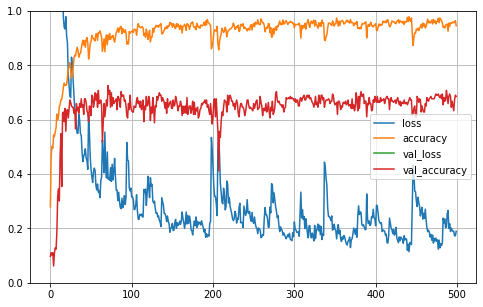

In [134]:
# plotting history
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [135]:
results = model.evaluate(x_train, y_train)
print('test loss: ' + str(results[0]) + ' test acc: ' + str(results[1]*100) + '%')

36/36 [==============================] - 0s 4ms/step - loss: 0.4372 - accuracy: 0.9369
test loss: 0.437162309885025 test acc: 93.69449615478516%


In [136]:
model.load_weights(PATH+'h5/cb_q.hdf5')

In [137]:
# saving model
import time
file_name = "model_cb_q"
model.save(PATH + 'h5/'+file_name+'.h5')

In [138]:
def rep_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(10).take(100):
    yield [input_value]

In [ ]:
def rep_data_gen():
    csvfile = open(PATH + 'train.csv')
    reader = csv.reader(x.replace('\0', '') for x in csvfile)
    labels = []
    
    for line in reader:
        if line == []:
            break
        tmp = [line[0],line[1]]
        labels.append(tmp)
    
    csvfile.close() 
    a = 0
    items= []
    import random
    for a in range(0,len(labels)-1):
        items.append(a)
    for i in random.sample(items,200):
        img = cv2.imread(PATH+'crop_img/'+labels[i][0])
        img = cv2.resize(img,size)
        img = tf.image.rgb_to_grayscale(img)
        yield [tf.reshape(np.array(img,dtype="float32"),[1,128,128,1])]

In [139]:
MODEL_NAME = "model_cb_q"
model = tf.keras.models.load_model(PATH + "h5/" + MODEL_NAME + ".h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open (PATH + "tflite/" + MODEL_NAME + "_origin.tflite" , "wb").write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpxlxsnbsi/assets


INFO:tensorflow:Assets written to: /tmp/tmpxlxsnbsi/assets


129072

In [142]:
# Quantize Conversion

MODEL_NAME = "model_cb_q"
model = tf.keras.models.load_model(PATH + "h5/" + MODEL_NAME + ".h5")
# model = tf.keras.models.load_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = rep_data_gen
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tfmodel = converter.convert()
open (PATH + "tflite/" + MODEL_NAME + "_quant.tflite" , "wb").write(tfmodel)


INFO:tensorflow:Assets written to: /tmp/tmpeo45nlcw/assets


INFO:tensorflow:Assets written to: /tmp/tmpeo45nlcw/assets


43984

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[4.6781348e-05, 6.8705975e-07, 6.7658578e-03, 9.3754816e-06,
        3.1533952e-07, 9.9317694e-01]], dtype=float32)

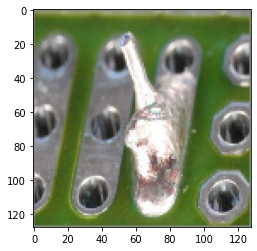

In [112]:
img = cv2.imread(PATH+'Image/1.jpeg')
img = cv2.resize(img,size)
plt.imshow(img)
img = tf.image.rgb_to_grayscale(img)
img = tf.reshape(np.array(img,dtype="float32"),[1,128,128,1])
model.predict(img)

In [140]:
import tensorflow as tf

TF_MODEL_NAME = 'model_cb_q_origin'

interpreter = tf.lite.Interpreter(PATH + 'tflite/' + TF_MODEL_NAME + '.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'conv2d_74_input', 'index': 0, 'shape': array([  1, 128, 128,   1], dtype=int32), 'shape_signature': array([ -1, 128, 128,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 49, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [143]:
import tensorflow as tf

TF_MODEL_NAME = 'model_cb_q_quant'

interpreter = tf.lite.Interpreter(PATH + 'tflite/' + TF_MODEL_NAME + '.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'conv2d_74_input', 'index': 0, 'shape': array([  1, 128, 128,   1], dtype=int32), 'shape_signature': array([ -1, 128, 128,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00392117677256465, -128), 'quantization_parameters': {'scales': array([0.00392118], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 49, 'shape': array([1, 6], dtype=int32), 'shape_signature': array([-1,  6], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [141]:
interpreter = tf.lite.Interpreter(model_path=PATH + 'tflite/' + TF_MODEL_NAME + '.tflite')
interpreter.allocate_tensors()
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_output_details()[0]['quantization']

    prediction_values = []

    for test_image in x_train[:100]:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0) #.astype(np.float32)
        #test_image = np.int8(test_image / scale + zero_point)
        test_image = np.float32(test_image)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)

    accurate_count = 0
    print(prediction_values)
    for index in range(len(y_train[:100])):
        if np.argmax(y_train[index]) == prediction_values[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(y_train[:100])

    return accuracy * 100

print("Accuracy: ", evaluate_model(interpreter))

[[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]
[5, 0, 5, 2, 0, 1, 2, 0, 3, 5, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 0, 0, 2, 5, 0, 0, 5, 1, 0, 5, 5, 0, 3, 2, 2, 0, 0, 5, 5, 0, 0, 0, 4, 0, 3, 0, 5, 3, 2, 5, 0, 0, 0, 5, 2, 0, 0, 5, 0, 5, 3, 0, 5, 1, 5, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 2, 0, 4, 0, 0, 5, 0, 3, 0, 3, 2, 0, 0, 2, 0, 0, 1, 3, 0, 0]
Accuracy:  98.0


In [146]:
interpreter = tf.lite.Interpreter(model_path=PATH + 'tflite/' + TF_MODEL_NAME + '.tflite')
interpreter.allocate_tensors()
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_input_details()[0]['quantization']
    print("Scale:", scale)
    print("Zero_point", zero_point)
    prediction_values = []

    for test_image in x_train[:100]:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0) #.astype(np.float32)
        test_image = np.int8(test_image / scale + zero_point)
        #test_image = np.float32(test_image)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)

    accurate_count = 0
    print(prediction_values)
    for index in range(len(y_train[:100])):
        if np.argmax(y_train[index]) == prediction_values[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(y_train[:100])

    return accuracy * 100

print("Accuracy: ", evaluate_model(interpreter))

Scale: 0.00392117677256465
Zero_point -128
[5, 0, 5, 2, 0, 1, 2, 0, 3, 5, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 0, 0, 2, 5, 0, 0, 5, 1, 0, 5, 5, 0, 3, 2, 2, 0, 0, 5, 5, 0, 0, 0, 4, 0, 3, 0, 5, 3, 2, 5, 0, 0, 0, 5, 2, 0, 0, 5, 0, 5, 3, 0, 5, 1, 5, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 2, 0, 4, 0, 0, 5, 0, 3, 0, 3, 2, 0, 0, 2, 0, 0, 1, 3, 5, 0]
Accuracy:  99.0
